ACTOR CRITIC SINGLE UAV

Episode 0/1000, Reward: -55
Episode 1/1000, Reward: -44
Episode 2/1000, Reward: -174
Episode 3/1000, Reward: -81
Episode 4/1000, Reward: -60
Episode 5/1000, Reward: -21
Episode 6/1000, Reward: -134
Episode 7/1000, Reward: -55
Episode 8/1000, Reward: -65
Episode 9/1000, Reward: -46
Episode 10/1000, Reward: -90
Episode 11/1000, Reward: -4
Episode 12/1000, Reward: -116
Episode 13/1000, Reward: -82
Episode 14/1000, Reward: -94
Episode 15/1000, Reward: -86
Episode 16/1000, Reward: -110
Episode 17/1000, Reward: -39
Episode 18/1000, Reward: -52
Episode 19/1000, Reward: -119
Episode 20/1000, Reward: -40
Episode 21/1000, Reward: -11
Episode 22/1000, Reward: -30
Episode 23/1000, Reward: -58
Episode 24/1000, Reward: -98
Episode 25/1000, Reward: -43
Episode 26/1000, Reward: -14
Episode 27/1000, Reward: -53
Episode 28/1000, Reward: -38
Episode 29/1000, Reward: -52
Episode 30/1000, Reward: -33
Episode 31/1000, Reward: -64
Episode 32/1000, Reward: -34
Episode 33/1000, Reward: -31
Episode 34/1000, Rew

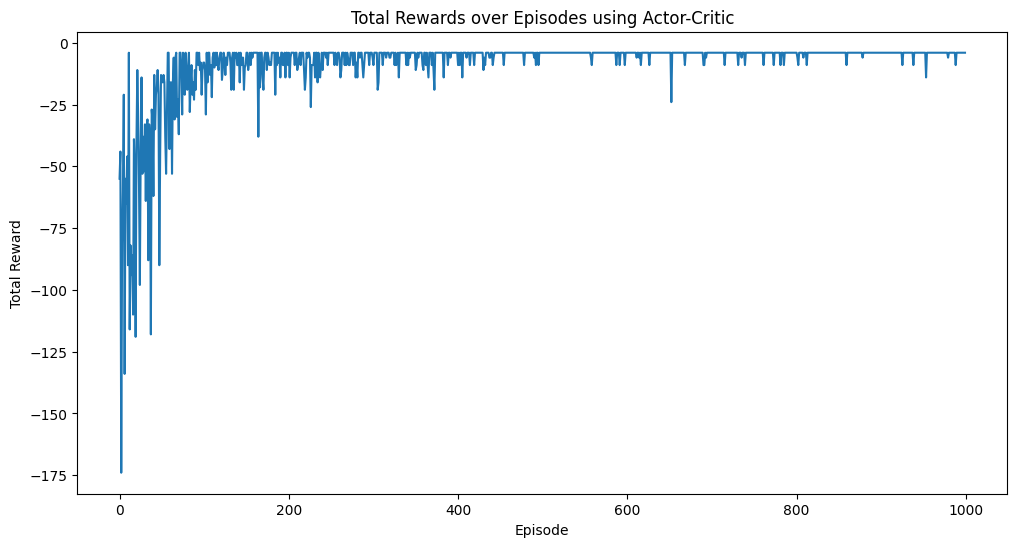

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# UAV Environment
class EnhancedSmallUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -5, False  # Negative reward for attempting to leave the grid

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 1, True  # Positive reward for reaching the goal

        return self.get_state(), -1, False  # Small negative reward for each step

# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Actor-Critic Training Function
def train_actor_critic(env, actor, critic, episodes=1000, gamma=0.99, lr=0.001, max_steps=50):
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
    all_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        total_reward = 0
        
        for steps in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = actor(state_tensor)
            value = critic(state_tensor)
            
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            
            log_prob = action_dist.log_prob(action)
            log_probs.append(log_prob)
            values.append(value)
            
            next_state, reward, done = env.step(action.item())
            rewards.append(reward)
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        all_rewards.append(total_reward)
        returns = compute_returns(rewards, gamma)
        actor_loss, critic_loss = compute_actor_critic_loss(returns, log_probs, values)
        
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        
        actor_loss.backward()
        critic_loss.backward()
        
        actor_optimizer.step()
        critic_optimizer.step()
        
        print(f"Episode {episode}/{episodes}, Reward: {total_reward}")
    
    return all_rewards

def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

def compute_actor_critic_loss(returns, log_probs, values):
    returns = torch.tensor(returns)
    values = torch.stack(values).squeeze()
    log_probs = torch.stack(log_probs)
    
    advantage = returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    return actor_loss, critic_loss

# Initialize and train the actor-critic model
# Initialize and train the actor-critic model
env = EnhancedSmallUAVEnv()
actor = Actor(input_dim=4, output_dim=4)
critic = Critic(input_dim=4)
rewards_ac = train_actor_critic(env, actor, critic, episodes=1000)

# Plotting the rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards_ac)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards over Episodes using Actor-Critic')
plt.show()


ACTOR CRITIC SINGLE UAV (Episode=100000)

Episode 0/10000, Reward: -94
Episode 1/10000, Reward: -24
Episode 2/10000, Reward: -61
Episode 3/10000, Reward: -17
Episode 4/10000, Reward: -45
Episode 5/10000, Reward: -69
Episode 6/10000, Reward: -63
Episode 7/10000, Reward: -61
Episode 8/10000, Reward: -56
Episode 9/10000, Reward: -126
Episode 10/10000, Reward: -31
Episode 11/10000, Reward: -21
Episode 12/10000, Reward: -11
Episode 13/10000, Reward: -54
Episode 14/10000, Reward: -106
Episode 15/10000, Reward: -14
Episode 16/10000, Reward: -16
Episode 17/10000, Reward: -4
Episode 18/10000, Reward: -51
Episode 19/10000, Reward: -57
Episode 20/10000, Reward: -18
Episode 21/10000, Reward: -32
Episode 22/10000, Reward: -25
Episode 23/10000, Reward: -9
Episode 24/10000, Reward: -164
Episode 25/10000, Reward: -6
Episode 26/10000, Reward: -21
Episode 27/10000, Reward: -4
Episode 28/10000, Reward: -64
Episode 29/10000, Reward: -75
Episode 30/10000, Reward: -68
Episode 31/10000, Reward: -28
Episode 32/10000, Reward: -30
Episode 33/10000, Rew

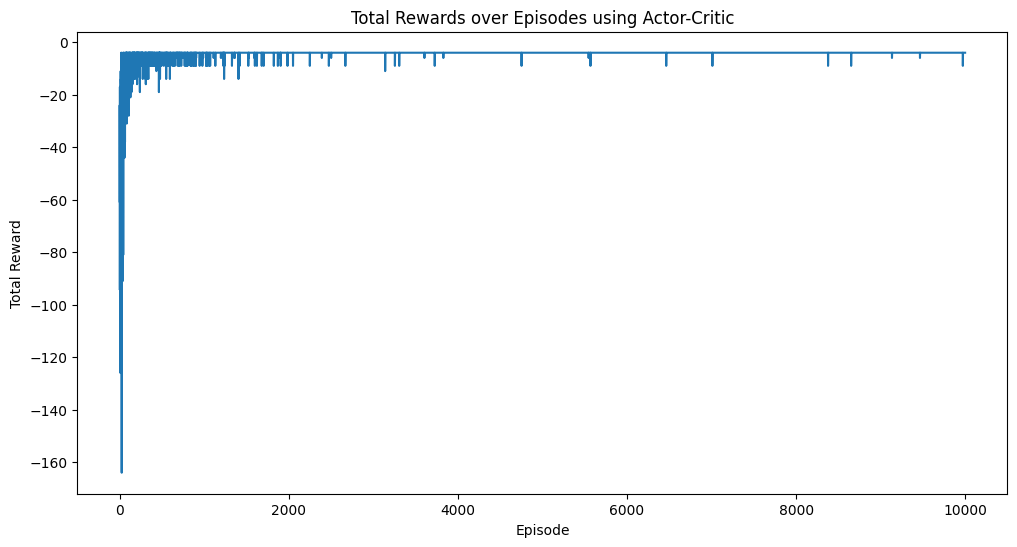

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# UAV Environment
class EnhancedSmallUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -5, False  # Negative reward for attempting to leave the grid

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 1, True  # Positive reward for reaching the goal

        return self.get_state(), -1, False  # Small negative reward for each step

# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Actor-Critic Training Function
def train_actor_critic(env, actor, critic, episodes=1000, gamma=0.99, lr=0.001, max_steps=50):
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
    all_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        total_reward = 0
        
        for steps in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = actor(state_tensor)
            value = critic(state_tensor)
            
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            
            log_prob = action_dist.log_prob(action)
            log_probs.append(log_prob)
            values.append(value)
            
            next_state, reward, done = env.step(action.item())
            rewards.append(reward)
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        all_rewards.append(total_reward)
        returns = compute_returns(rewards, gamma)
        actor_loss, critic_loss = compute_actor_critic_loss(returns, log_probs, values)
        
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        
        actor_loss.backward()
        critic_loss.backward()
        
        actor_optimizer.step()
        critic_optimizer.step()
        
        print(f"Episode {episode}/{episodes}, Reward: {total_reward}")
    
    return all_rewards

def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

def compute_actor_critic_loss(returns, log_probs, values):
    returns = torch.tensor(returns)
    values = torch.stack(values).squeeze()
    log_probs = torch.stack(log_probs)
    
    advantage = returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    return actor_loss, critic_loss

# Initialize and train the actor-critic model
# Initialize and train the actor-critic model
env = EnhancedSmallUAVEnv()
actor = Actor(input_dim=4, output_dim=4)
critic = Critic(input_dim=4)
rewards_ac = train_actor_critic(env, actor, critic, episodes=10000)

# Plotting the rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards_ac)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards over Episodes using Actor-Critic')
plt.show()


ACTOR CRITIC MODEL SINGLE AGENT-Hyperparameter 조절

Episode 0/10000, Reward: -40
Episode 1/10000, Reward: -138
Episode 2/10000, Reward: -35
Episode 3/10000, Reward: -23
Episode 4/10000, Reward: -79
Episode 5/10000, Reward: -45
Episode 6/10000, Reward: -30
Episode 7/10000, Reward: -46
Episode 8/10000, Reward: -18
Episode 9/10000, Reward: -22
Episode 10/10000, Reward: -87
Episode 11/10000, Reward: -184
Episode 12/10000, Reward: -116
Episode 13/10000, Reward: -117
Episode 14/10000, Reward: -18
Episode 15/10000, Reward: -97
Episode 16/10000, Reward: -59
Episode 17/10000, Reward: -48
Episode 18/10000, Reward: -61
Episode 19/10000, Reward: -27
Episode 20/10000, Reward: -30
Episode 21/10000, Reward: -71
Episode 22/10000, Reward: -42
Episode 23/10000, Reward: -31
Episode 24/10000, Reward: -24
Episode 25/10000, Reward: -52
Episode 26/10000, Reward: -67
Episode 27/10000, Reward: -37
Episode 28/10000, Reward: -131
Episode 29/10000, Reward: -38
Episode 30/10000, Reward: -73
Episode 31/10000, Reward: -149
Episode 32/10000, Reward: -15
Episode 33/100

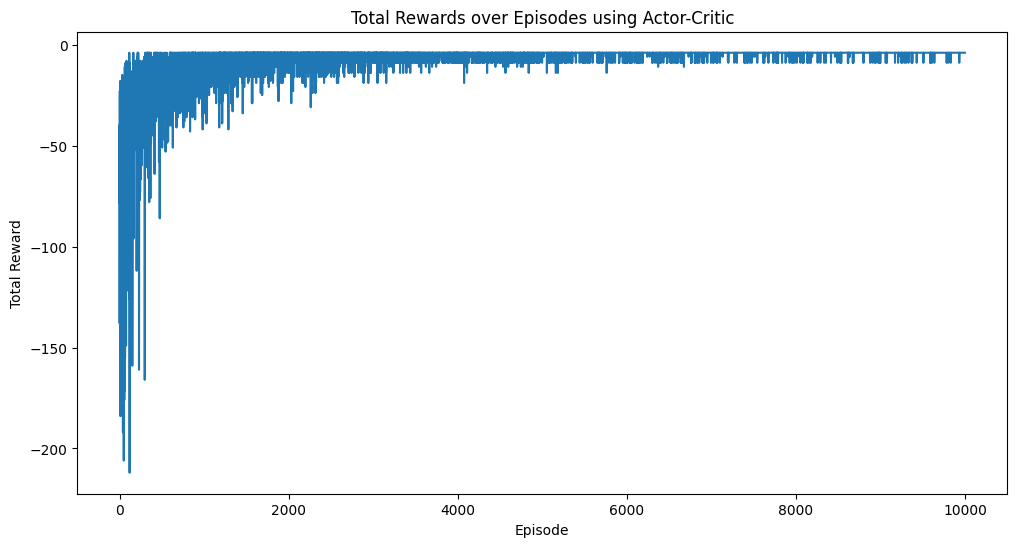

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# UAV Environment
class EnhancedSmallUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -5, False  # Negative reward for attempting to leave the grid

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 1, True  # Positive reward for reaching the goal

        return self.get_state(), -1, False  # Small negative reward for each step

# Define the Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Define the Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Actor-Critic Training Function
def train_actor_critic(env, actor, critic, episodes=10000, gamma=0.99, lr=0.0001, max_steps=100):
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
    all_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        total_reward = 0
        
        for steps in range(max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = actor(state_tensor)
            value = critic(state_tensor)
            
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            
            log_prob = action_dist.log_prob(action)
            log_probs.append(log_prob)
            values.append(value)
            
            next_state, reward, done = env.step(action.item())
            rewards.append(reward)
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        all_rewards.append(total_reward)
        returns = compute_returns(rewards, gamma)
        actor_loss, critic_loss = compute_actor_critic_loss(returns, log_probs, values)
        
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        
        actor_loss.backward()
        critic_loss.backward()
        
        actor_optimizer.step()
        critic_optimizer.step()
        
        print(f"Episode {episode}/{episodes}, Reward: {total_reward}")
    
    return all_rewards

def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

def compute_actor_critic_loss(returns, log_probs, values):
    returns = torch.tensor(returns)
    values = torch.stack(values).squeeze()
    log_probs = torch.stack(log_probs)
    
    advantage = returns - values
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    return actor_loss, critic_loss

# Initialize and train the actor-critic model
# Initialize and train the actor-critic model
env = EnhancedSmallUAVEnv()
actor = Actor(input_dim=4, output_dim=4)
critic = Critic(input_dim=4)
rewards_ac = train_actor_critic(env, actor, critic, episodes=10000)

# Plotting the rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards_ac)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards over Episodes using Actor-Critic')
plt.show()
